In [1]:
%load_ext autoreload

In [2]:
import sys
from timeit import default_timer as timer
import h5py
import numpy as np
import matplotlib.pyplot as plt

import keras

from evaluator import visualization as vis
from evaluator import defense
from evaluator.models.resnet import Resnet
from evaluator.models.model import CarliniCifarWrapper, RobustModel
from evaluator.dataset import CIFAR
from evaluator.utils import merge_and_generate_labels

%autoreload 2

/home/jungj/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/jungj/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/jungj/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/jungj/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will b

## Setup models and load weights

In [3]:
data = CIFAR()
path = "forks/nn_breaking_detection/models/cifar"
# MI model
resnet_mi = Resnet(data,bayesian=True) # this is a Bayesian model, make sure to use a non-Bayesian for LID!
model_mi = resnet_mi.model
model_mi.load_weights(path)
# MI model
resnet_lid = Resnet(data,bayesian=False)
model_lid = resnet_lid.model
model_lid.load_weights(path)

In [5]:
# check model accuracy
acc_mi = np.mean(np.argmax(model_mi.predict(data.test_data),axis=1) == np.argmax(data.test_labels,axis=1))
acc_lid = np.mean(np.argmax(model_lid.predict(data.test_data),axis=1) == np.argmax(data.test_labels,axis=1))
print("ACC MI",acc_mi)
print("ACC LID",acc_lid)

ACC MI 0.9195
ACC LID 0.9202


## Load some real and adversarial examples and plot them

(10000, 32, 32, 3)


(-0.5, 319.5, 31.5, -0.5)

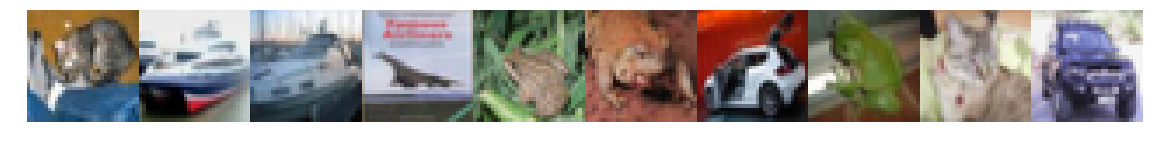

In [6]:
real = data.test_data #np.array(h5py.File('forks/nn_breaking_detection/adv_ex_10000.h5','r')['real'])
print(real.shape)
real_scaled = real - real.min()
plt.figure(figsize=(20,20))
plt.imshow(np.concatenate([real_scaled[i] for i in range(10)], axis=1))
plt.axis('off')

(10000, 32, 32, 3)


(-0.5, 319.5, 31.5, -0.5)

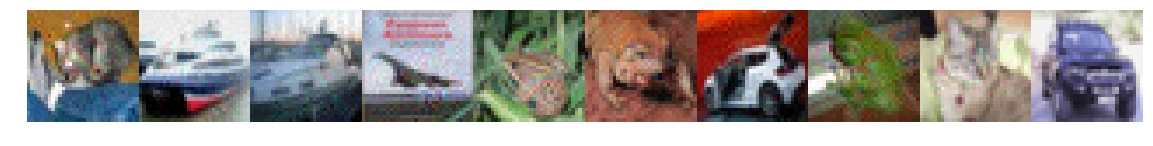

In [7]:
adv_johannes = np.array(h5py.File('forks/nn_breaking_detection/adv_ex_10000.h5','r')['adv'])
print(adv_johannes.shape)
adv_johannes_scaled = adv_johannes - adv_johannes.min()
plt.figure(figsize=(20,20))
plt.imshow(np.concatenate([adv_johannes_scaled[i] for i in range(10)], axis=1))
plt.axis('off')

(10000, 32, 32, 3)


(-0.5, 319.5, 31.5, -0.5)

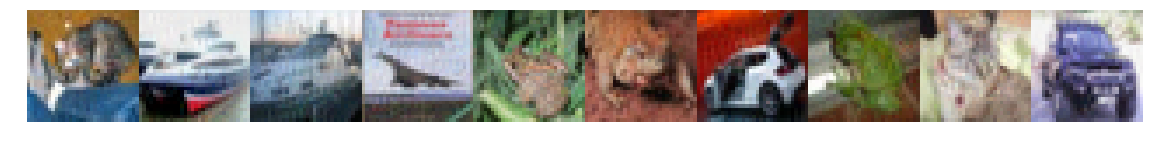

In [8]:
### adversarial examples created from LID code but using Johannes' parameters
adv_rajanie_newparameters = np.load('../LID_code/data/Adv_cifar_cw-l2.npy')
print(adv_rajanie_newparameters.shape)
adv_rajanie_scaled_newparameters = adv_rajanie_newparameters - adv_rajanie_newparameters.min()
plt.figure(figsize=(20,20))
plt.imshow(np.concatenate([adv_rajanie_scaled_newparameters[i] for i in range(10)], axis = 1))
plt.axis('off')


## Check model accuracy for adversarial data

In [19]:
pred_mi_johannes = np.argmax(model_mi.predict(adv_johannes),axis=1) == np.argmax(data.test_labels,axis=1)
acc_mi_johannes = np.mean(pred_mi_johannes)
pred_lid_johannes = np.argmax(model_lid.predict(adv_johannes),axis=1) == np.argmax(data.test_labels,axis=1)
acc_lid_johannes = np.mean(pred_lid_johannes)
# get the perturbation for these examples
dist_batch_johannes = np.sqrt(np.sum(np.square(real-adv_johannes),axis=(1,2,3)))
print("MEAN PERTURBATION for adversarial johannes", np.mean(dist_batch_johannes))
print("ACC MI for adversarial johannes",acc_mi_johannes)
print("ACC LID for adversarial johannes",acc_lid_johannes,"\n")
                           

pred_mi_rajanie = np.argmax(model_mi.predict(adv_rajanie_newparameters),axis=1) == np.argmax(data.test_labels,axis=1)
acc_mi_rajanie = np.mean(pred_mi_rajanie)
pred_lid_rajanie = np.argmax(model_lid.predict(adv_rajanie_newparameters),axis=1) == np.argmax(data.test_labels,axis=1)
acc_lid_rajanie = np.mean(pred_lid_rajanie)
# get the perturbation for these examples
dist_batch_rajanie = np.sqrt(np.sum(np.square(real-adv_rajanie_newparameters),axis=(1,2,3)))
print("MEAN PERTURBATION for adversarial rajanie new", np.mean(dist_batch_rajanie))
print("ACC MI for adversarial rajanie new",acc_mi_rajanie)
print("ACC LID for adversarial rajanie new",acc_lid_rajanie)

MEAN PERTURBATION for adversarial johannes 1.2410388665096463
ACC MI for adversarial johannes 0.1391
ACC LID for adversarial johannes 0.0971 

MEAN PERTURBATION for adversarial rajanie new 1.1066345865535707
ACC MI for adversarial rajanie new 0.7666
ACC LID for adversarial rajanie new 0.7706


The first set of adversarial exmaples is much stronger in fooling the models, even though the perturbation is quite similar.

In [23]:
adv_rajanie_newparameters.shape

(10000, 32, 32, 3)

### Get more insights for some adversarial exmaples

lid johannes
Number of not changed: (971,) number of changed: (9029,)


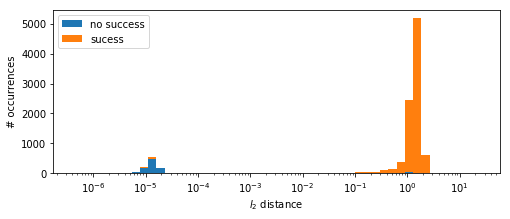

mi johannes
Number of not changed: (1391,) number of changed: (8609,)


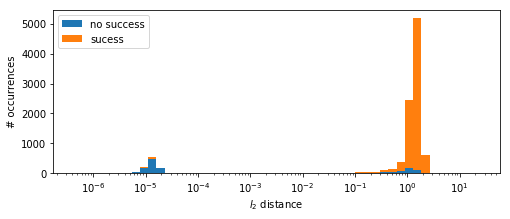

lid rajanie
Number of not changed: (7706,) number of changed: (2294,)


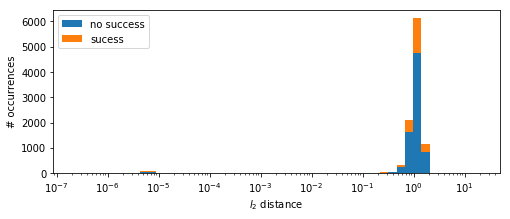

mi rajanie
Number of not changed: (7666,) number of changed: (2334,)


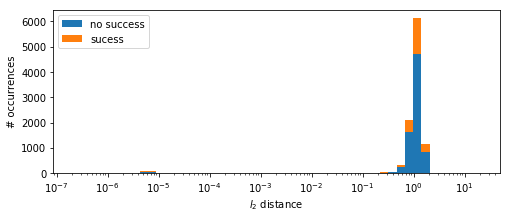

In [28]:
# What's the perturbation for the ones that changed the class vs those that didn't
def plot_success(dist_batch,class_equal):
    dist_equal = dist_batch[class_equal]
    dist_changed = dist_batch[np.invert(class_equal)]
    print("Number of not changed:",dist_equal.shape, "number of changed:",dist_changed.shape)
    
    data = np.array([dist_equal, dist_changed])
    names = ["no success", "sucess"]

    # under the assumption that negative values don't make much sense for a measure, we clip them ...
    data = [np.clip(x, 1e-30,None) for x in data]
    log_min = np.min([np.log10(np.min(x)) - 1 for x in data])
    log_max = np.max([np.log10(np.max(x)) + 1 for x in data])
    bins = np.logspace(log_min, log_max, 50)
    data = [x for x in data]

    plt.figure(figsize=(8, 3))
    plt.xscale('log')
    plt.hist(data,
             bins=bins,
             label=names,
             stacked=True)
    plt.xlabel('$l_2$ distance')
    plt.ylabel('# occurrences')
    plt.legend()
    plt.show()

plots = {"lid johannes": (dist_batch_johannes, pred_lid_johannes),
         "mi johannes": (dist_batch_johannes, pred_mi_johannes),
         "lid rajanie": (dist_batch_rajanie, pred_lid_rajanie),
         "mi rajanie": (dist_batch_rajanie, pred_mi_rajanie),
        } 

for name, data in plots.items():
    print(name)
    plot_success(*data)

#### Get MI

In [38]:
sess = keras.backend.get_session()
mi_defense = defense.MutualInformation(model_mi,sess)
mi_real = mi_defense(real, mc_passes=30)
mi_adv = mi_defense(adv_johannes, mc_passes=30)

Predicted outputs with shape (10000, 30, 10) and 30 MC passes


/home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:73: Warning: negative values in mutual information, shape: (724,)
  "negative values in mutual information, shape: {}".format(negative_mi.shape), Warning)


Predicted outputs with shape (10000, 30, 10) and 30 MC passes


/home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:73: Warning: negative values in mutual information, shape: (285,)
  "negative values in mutual information, shape: {}".format(negative_mi.shape), Warning)


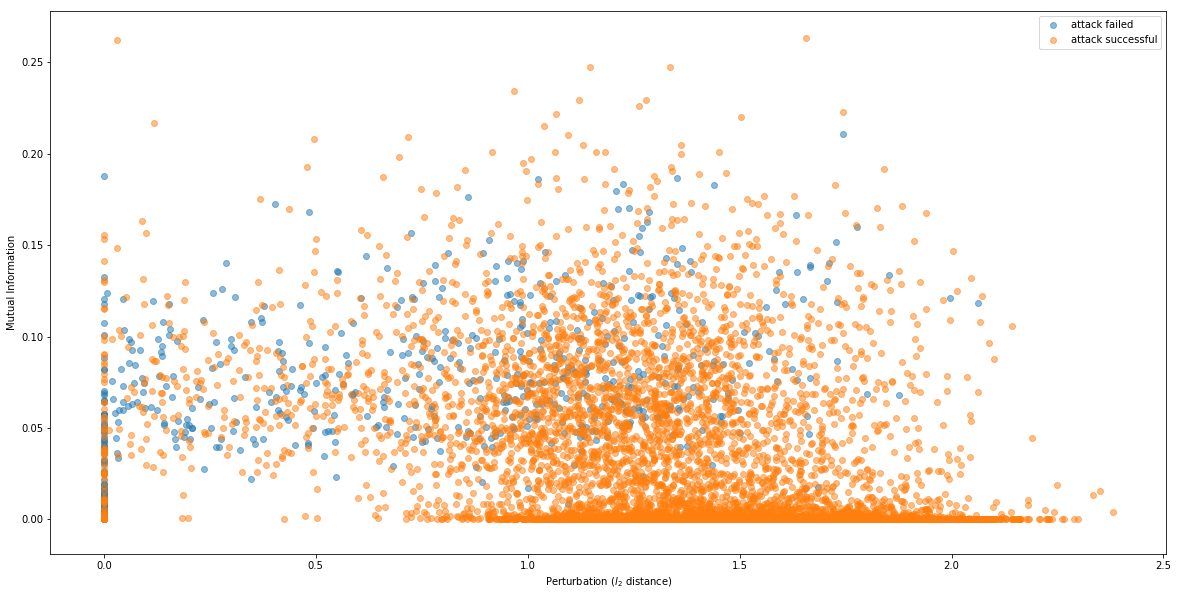

In [39]:
plt.figure(figsize=(20,10))
plt.scatter(dist_batch_johannes[pred_mi_johannes],mi_adv[pred_mi_johannes],label="attack failed",alpha=0.5)
plt.scatter(dist_batch_johannes[np.invert(pred_mi_johannes)],mi_adv[np.invert(pred_mi_johannes)],label="attack successful",alpha=0.5)
plt.xlabel("Perturbation ($l_2$ distance)")
plt.ylabel("Mutual Information")
plt.legend()
plt.show()

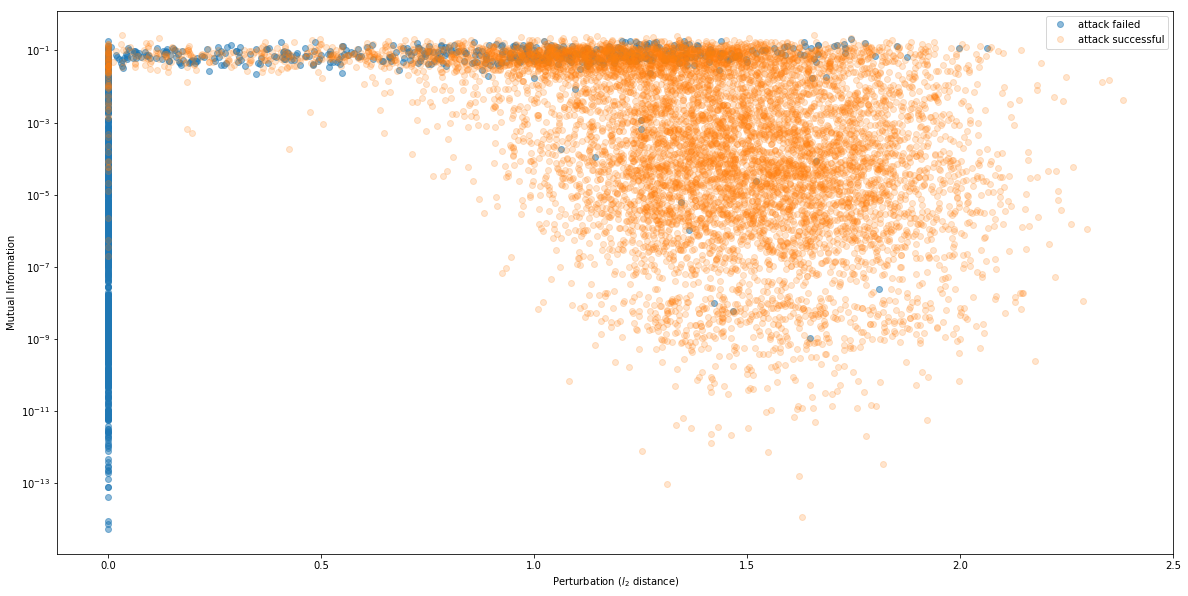

In [42]:
plt.figure(figsize=(20,10))
plt.plot(dist_batch_johannes[pred_mi_johannes],mi_adv[pred_mi_johannes],label="attack failed",alpha=0.5,marker='o',linewidth=0)
plt.plot(dist_batch_johannes[np.invert(pred_mi_johannes)],mi_adv[np.invert(pred_mi_johannes)],label="attack successful",alpha=0.2,marker='o',linewidth=0)
plt.yscale('log')
plt.xlabel("Perturbation ($l_2$ distance)")
plt.ylabel("Mutual Information")
plt.legend()
plt.show()

# Get LIDs for non-Bayesian model

In [32]:
sess = keras.backend.get_session()
runs = 100
N = 100
k = 20
batch_sizes = list(range(20,105,10))
test_adv_lid = np.zeros((len(batch_sizes),runs,N))
test_real_lid = np.zeros((len(batch_sizes),runs,N))
real_data = real[:N]
adv_data = adv_johannes[:N]
for b, batch_size in enumerate(batch_sizes):
    print("Batch size", batch_size)
    for i in range(runs):
        perm = np.random.permutation(N)
        real_perm = real_data[perm]
        adv_perm = adv_data[perm]
        Lid100 = defense.LID(model_lid,sess,real_perm, adv_perm, k=k, batch_size = batch_size)
#         print(" -- run ", i)
        real_lid, adv_lid = Lid100.lid_scores(layers=[-1])
        inv_perm = np.argsort(perm)
        test_adv_lid[b,i,:] = np.squeeze(adv_lid)[inv_perm]
        test_real_lid[b,i,:] = np.squeeze(real_lid)[inv_perm]

9
Batch size 20
Batch size 30
Batch size 40
Batch size 50
Batch size 60
Batch size 70
Batch size 80
Batch size 90
Batch size 100


In [33]:
test_adv_lid.shape

(9, 1, 100)

In [319]:
stds = np.std(test_adv_lid,axis=(1))
means = np.mean(test_adv_lid,axis=(1))

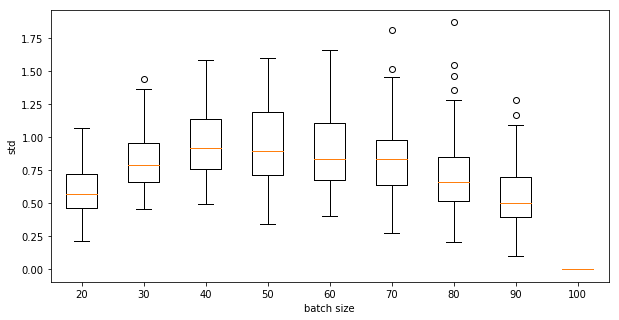

In [320]:
plt.figure(figsize=(10,5))
plt.boxplot(np.swapaxes(stds,0,1))
plt.xlabel("batch size")
plt.ylabel("std")
# plt.ylim(0,2)
plt.xticks(list(range(1,10)), batch_sizes)
plt.show()

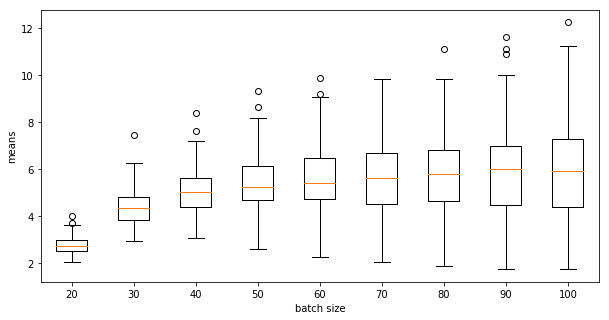

In [321]:
plt.figure(figsize=(10,5))
plt.boxplot(np.swapaxes(means,0,1))
plt.xlabel("batch size")
plt.ylabel("means")
plt.xticks(list(range(1,10)), batch_sizes)
plt.show()

# Plot LID vs perturbation

In [34]:
Lid = defense.LID(model_lid,sess, real, adv_johannes, k= 20, batch_size = 100)
lids_real, lids_adv = Lid.lid_scores(layers=[-1])

In [292]:
lids_real = lids_real.reshape(-1,)
lids_adv = lids_adv.reshape(-1,)

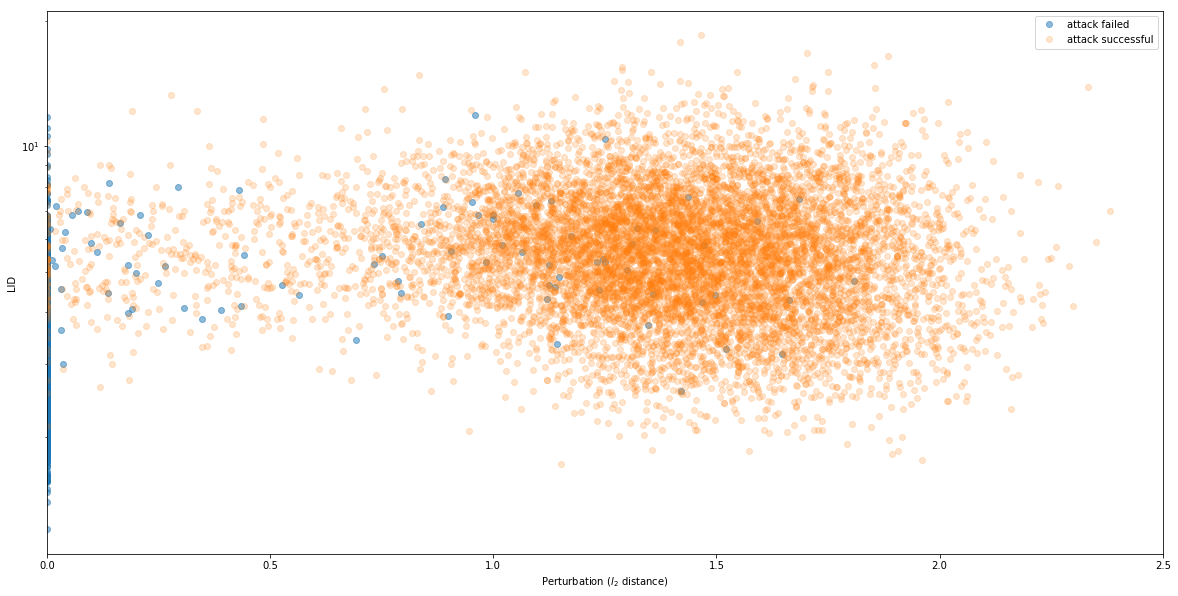

In [37]:
plt.figure(figsize=(20,10))
plt.plot(dist_batch_johannes[pred_lid_johannes],lids_adv[pred_lid_johannes],label="attack failed",alpha=0.5,marker='o',linewidth=0)
plt.plot(dist_batch_johannes[np.invert(pred_lid_johannes)],lids_adv[np.invert(pred_lid_johannes)],label="attack successful",alpha=0.2,marker='o',linewidth=0)
plt.yscale('log')
plt.xlim(0,2.5)
plt.xlabel("Perturbation ($l_2$ distance)")
plt.ylabel("LID")
plt.legend()
plt.show()

### the following cells contain some work in progress... just ignore them ;)

In [187]:
mi_adv_copy = np.copy(mi_adv)
mi_real_copy = np.copy(mi_real)

In [190]:
mi_adv = mi_adv_copy
mi_real = mi_real_copy

/home/jungj/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:936: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fecf81bd588>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/home/jungj/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:936: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fecf8577898>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


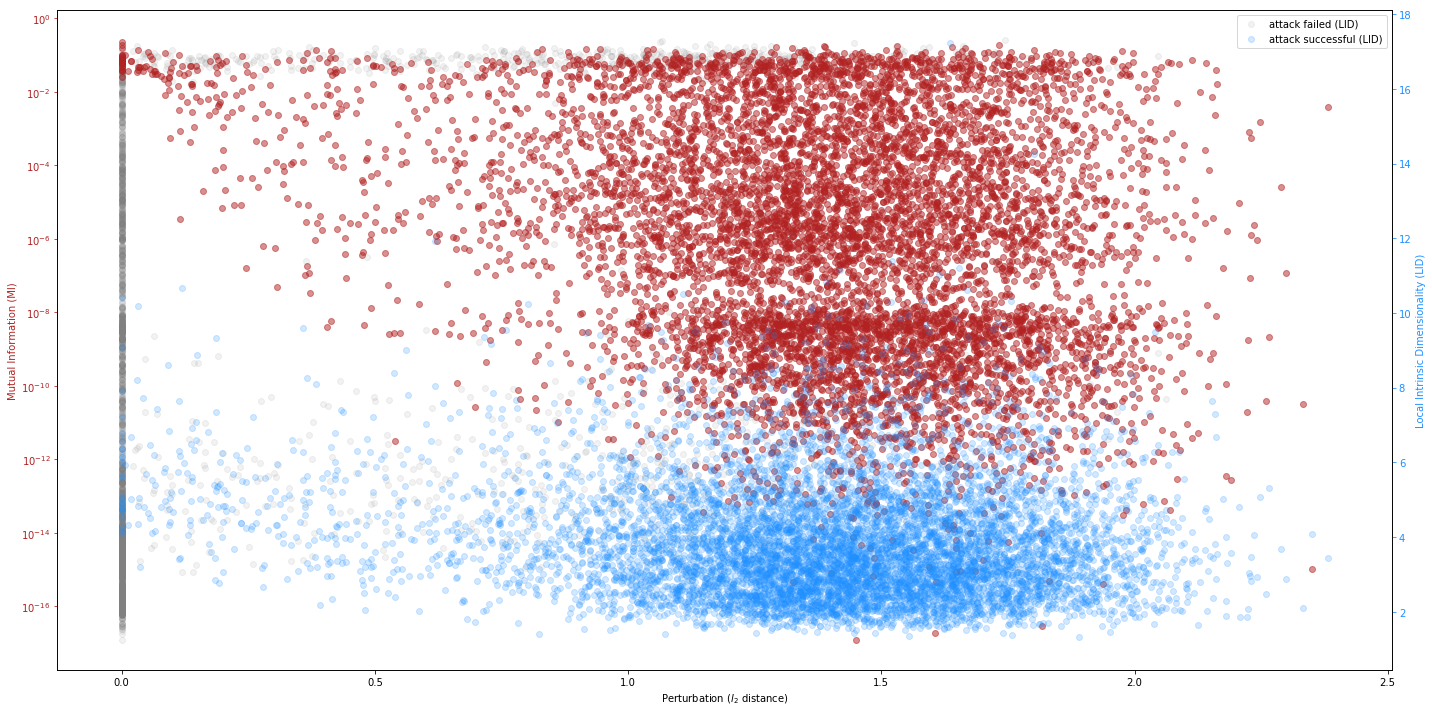

In [201]:
# failed attacks have a very similar dist. therefore we use the same color for visualizing those for MI and LID

fig, ax1 = plt.subplots(figsize=(20,10))


p1 = ax1.semilogy(dist_batch[class_equal],mi_adv[class_equal],'o',alpha=0.1,color='gray')
p2 = ax1.semilogy(dist_batch[np.invert(class_equal)],mi_real[np.invert(class_equal)],'o',alpha=0.5,color='firebrick')
ax1.set_xlabel('Perturbation ($l_2$ distance)')
ax1.set_ylabel('Mutual Information (MI)', color='firebrick')
ax1.tick_params('y', colors='firebrick')

ax2 = ax1.twinx()
p3 = ax2.scatter(dist_batch[class_equal],lids_adv[class_equal],alpha=0.1,color='gray')
p4 = ax2.scatter(dist_batch[np.invert(class_equal)],lids_real[np.invert(class_equal)],alpha=0.2,color='dodgerblue')
ax2.set_ylabel('Local Intrinsic Dimensionality (LID)', color='dodgerblue')
ax2.tick_params('y', colors='dodgerblue')

plt.legend([p1,p3,p2,p4],["attack failed (MI)","attack failed (LID)","attack successful (MI)","attack successful (LID)"])

fig.tight_layout()
plt.show()